<font size = +3><b><u><center> Data Modeling </center></u></b></font>

In [2]:
#  Python Standard Packages
import itertools
import joblib
import re
import string
import time

#  Conda Standard Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score, \
                            precision_recall_curve, PrecisionRecallDisplay, make_scorer, RocCurveDisplay
from sklearn.model_selection import cross_val_score, cross_validate, \
                                    GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, \
                                  Normalizer, StandardScaler, RobustScaler
from sklearn.svm import LinearSVC

#  Third-Party Packages
import dill as pickle
import eli5
from tqdm import tqdm

In [33]:
#  Set Up Options
%precision %.3f
pd.set_option('display.float_format', '{:.2f}'.format)

'''Set Up Time Tracking Functions for Pandas'''
tqdm.pandas()

In [4]:
%%html 
<style>
table {float:left}
</style>

---

# &nbsp;&nbsp; I. &nbsp; Pre-Model Set-Up

## Load Data From Pickle:

In [6]:
df = pd.read_pickle('./data/fulldataclean.tar.gz', compression='infer')

In [7]:
df

,target,text,neg,neu,pos,compound,anger,disgust,fear,sadness,anticipation,joy,surprise,trust
0,1,ex wife threaten suicide recently leave wife g...,0.192,0.733,0.075,-0.949,8.000,4.000,8.000,6.000,7.000,5.000,5.000,5.000
1,0,weird get affect compliment come someone know ...,0.038,0.756,0.206,0.719,0.000,1.000,0.000,0.000,2.000,1.000,1.000,2.000
2,0,finally almost never hear bad year ever swear ...,0.259,0.665,0.076,-0.700,2.000,2.000,2.000,1.000,2.000,2.000,1.000,3.000
3,1,need help help cry hard,0.286,0.403,0.311,0.111,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
4,1,lose hello name adam struggle year afraid past...,0.193,0.731,0.076,-0.995,18.000,10.000,27.000,26.000,20.000,6.000,5.000,9.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232069,0,like rock go get anything go,0.080,0.920,0.000,-0.142,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
232070,0,tell many friend lonely everything deprive pre...,0.085,0.765,0.150,0.337,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000
232071,0,pee probably taste like salty tea someone drin...,0.000,0.839,0.161,0.361,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
232072,1,usual stuff find post sympathy pity know far b...,0.176,0.718,0.105,-0.989,9.000,6.000,7.000,10.000,3.000,1.000,1.000,3.000


In [8]:
# Make sure no missing data

df.isna().sum()

target          0
text            0
neg             0
neu             0
pos             0
compound        0
anger           0
disgust         0
fear            0
sadness         0
anticipation    0
joy             0
surprise        0
trust           0
dtype: int64

In [9]:
# All data is correct datatype:

df.dtypes

target            int64
text             object
neg             float64
neu             float64
pos             float64
compound        float64
anger           float64
disgust         float64
fear            float64
sadness         float64
anticipation    float64
joy             float64
surprise        float64
trust           float64
dtype: object

In [11]:
def nonstring_data(series):

    problem_list = []
    for ind in series.index:
        if not isinstance(series.loc[ind], str):
            problem_list.append(ind)
    return problem_list


problems1 = nonstring_data(df['text'])
print(problems1)

[]


---

## Define X & Y

In [13]:
X = df.drop(['target'], axis=1)
y = df['target']

In [14]:
X.head()

,text,neg,neu,pos,compound,anger,disgust,fear,sadness,anticipation,joy,surprise,trust
0,ex wife threaten suicide recently leave wife g...,0.192,0.733,0.075,-0.949,8.000,4.000,8.000,6.000,7.000,5.000,5.000,5.000
1,weird get affect compliment come someone know ...,0.038,0.756,0.206,0.719,0.000,1.000,0.000,0.000,2.000,1.000,1.000,2.000
2,finally almost never hear bad year ever swear ...,0.259,0.665,0.076,-0.700,2.000,2.000,2.000,1.000,2.000,2.000,1.000,3.000
3,need help help cry hard,0.286,0.403,0.311,0.111,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
4,lose hello name adam struggle year afraid past...,0.193,0.731,0.076,-0.995,18.000,10.000,27.000,26.000,20.000,6.000,5.000,9.000


In [15]:
y.head()

0    1
1    0
2    0
3    1
4    1
Name: target, dtype: int64

## Train-Test Split

* Split Ratio: 70% train, 15% val, 15% test

In [16]:
len(X)

230072

In [17]:
print(f'{len(df)*.7:.0f}:{len(df)*.15:.0f}:{len(df)*.15:.0f}')
print('\t')
print(f'Sum: {161050+34511+34511}')

161050:34511:34511
	
Sum: 230072


In [18]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=34511, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=34511, random_state=42)

In [19]:
print(f"X - Size - Train: {len(X_train)}, Val: {len(X_val)}, Test:{len(X_test)}")

print(f"X - Perc - Train: {len(X_train)/len(X)*100:.1f}%, Val: {len(X_val)/len(df)*100:.1f}%, Test:{len(X_test)/len(df)*100:.1f}%")

X - Size - Train: 161050, Val: 34511, Test:34511
X - Perc - Train: 70.0%, Val: 15.0%, Test:15.0%


In [20]:
print(f"y - Size - Train: {len(y_train)}, Val: {len(y_val)}, Test:{len(y_test)}")
print(f"y - Perc - Train: {len(y_train)/len(y)*100:.1f}%, Val: {len(y_val)/len(df)*100:.1f}%, Test:{len(y_test)/len(df)*100:.1f}%")

y - Size - Train: 161050, Val: 34511, Test:34511
y - Perc - Train: 70.0%, Val: 15.0%, Test:15.0%


---

## Functions for Metrics

1. Confusion Matrix Plotting - [original source](https://github.com/flatiron-school/ntl01-dtsc-live-103122/tree/main/4Phase/src)

In [21]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
class Metrics:
    def __init__(self):
        self.df = pd.DataFrame(columns=['name', 'clf', 'cv_mean', 'train', 'acc', 'prec', 'rec', 'time'])

    def get_metrics(self, name, clf, pipe, Xtr, ytr, Xval, yval):
        """Method to print metrics and return df of metrics"""

        start = time.time()
        metric_dict = {'name': name, 'clf': clf}
        pipe.fit(Xtr, ytr)
        base_cv = pd.DataFrame(cross_validate(pipe, Xtr, ytr, cv=3, return_train_score=False)).mean()
        metric_dict['cv_mean'] = base_cv[2].mean()*100

        if clf == 'rfc':
            metric_dict['train'] = pipe[clf].oob_score_*100
        else:
            yhat = pipe.predict(Xtr)
            metric_dict['train'] = accuracy_score(ytr, yhat)*100

        ypred = pipe.predict(Xval)
        metric_dict['acc'] = accuracy_score(yval, ypred)*100

        print(f"TRAIN accuracy: {metric_dict['train']: .2f} %")
        print("VAL:")
        print(f"Accuracy: {metric_dict['acc']: .2f} %")

        if clf != 'dummy':
            metric_dict['rec'] = recall_score(yval, ypred)*100
            metric_dict['prec'] = precision_score(yval, ypred)*100
            print(f"Recall: {metric_dict['rec']*100: .2f} %")
            print(f"Precision: {metric_dict['prec']: .2f} %")
            conf = confusion_matrix(yval, ypred)
            plot_confusion_matrix(conf, classes=["non-risk", "suicide risk"], normalize=True)
            print(classification_report(yval, ypred, labels=[0,1]))

        end = time.time()
        metric_dict['time'] = (f'{end-start:.1f} s')

        self.df = pd.concat([self.df, pd.DataFrame(metric_dict, index=[0])], ignore_index=True)
        return self

In [23]:
met = Metrics()

In [24]:
met.df

,name,clf,cv_mean,train,acc,prec,rec,time


## Create Column Transformer Prep Pipeline

* Separate Pipeline needed for text and numeric (emotion/sentiment) columns
* Using MinMaxScaler to avoid negative & zero values
    * Might change to StandardScaler depending on model & normalization

In [25]:
# Num_Pipe includes MinMaxScaler since MNB cannot handle negative values

num_pipe = Pipeline(steps=[
    ('min', MinMaxScaler())
])

text_pipe = Pipeline(steps=[
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("tfidf", TfidfVectorizer(min_df=0.05, max_df=0.95)),
    ("toarray", FunctionTransformer(lambda x: x.toarray()))
])

CT = ColumnTransformer(transformers=[
    ('num', num_pipe, selector(dtype_include=np.number)),
    ('text', text_pipe, ['text'])
])

# &nbsp;&nbsp; II. &nbsp; Data Modeling

## Metrics to Focus On

1. **High Accuracy Rate**: We want a model that can successfully distinguish suicide risk cases from non-suicide risk cases
2. **High Recall Rate**: We want to *avoid* failing to detect suicide risk cases, meaning we want a high recall rate.

## 1. Baseline and First Simple Model

In [26]:
X_bas_train = X_train['text']
X_bas_val = X_val['text']

print("Data for Basic (tf-idf only) models: X_bas_")

Data for Basic (tf-idf only) models: X_bas_


### 1a. Baseline Model

In [27]:
base_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(min_df=0.05, max_df=0.95)),
    ('dummy', DummyClassifier())
])

In [28]:
met.get_metrics('baseline', 'dummy', base_pipe, X_bas_train, y_train, X_bas_val, y_val)

TRAIN accuracy:  50.29 %
VAL:
Accuracy:  50.40 %


#### Summary of Baseline Model

* 50% accuracy in classifying suicide risk vs. non-risk
    * Expected value given equal class balance

### 1b. First Simple Model

In [30]:
fsm_pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(min_df=0.05, max_df=0.95)),
    ('mnb', MultinomialNB())
])

TRAIN accuracy:  80.47 %
VAL:
Accuracy:  80.84 %
Recall:  8750.14 %
Precision:  77.42 %
Normalized confusion matrix
[[0.74072559 0.25927441]
 [0.12498563 0.87501437]]
              precision    recall  f1-score   support

           0       0.85      0.74      0.79     17117
           1       0.77      0.88      0.82     17394

    accuracy                           0.81     34511
   macro avg       0.81      0.81      0.81     34511
weighted avg       0.81      0.81      0.81     34511



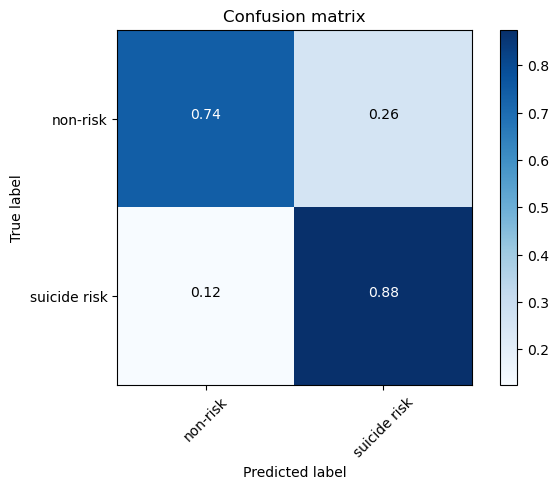

In [31]:
met.get_metrics('fsm', 'mnb', fsm_pipe, X_bas_train, y_train, X_bas_val, y_val)

In [32]:
met.df

,name,clf,cv_mean,train,acc,prec,rec,time
0,baseline,dummy,50.289,50.289,50.401,NaN,NaN,16.3 s
1,fsm,mnb,80.372,80.471,80.841,77.424,87.501,16.4 s


#### Summary of First Simple Model

* 80.8% Accuracy in classifying suicide risk
    * Model is well-fit -- (0.4% difference between Train & Test Accuracy)
    * Quick runtime
* Recall (87.5%) > Precision (77.4%)
    * In line with goal to avoid false negatives

### 1c. Extracting TFIDF and stopword data

In [34]:
stopwords = fsm_pipe['tfidf'].stop_words_

In [35]:
stopwords = list(stopwords)

In [37]:
print(f'List of custom Stopwords: {len(stopwords)}')
print('\t')
print(stopwords[:20])
print('\t')
print(stopwords[-20:])

List of custom Stopwords: 80116
	
['horrify', 'hmmwv', 'homily', 'boix', 'hyposexuality', 'schism', 'steamunlocked', 'fork', 'bunnygirl', 'appeartnly', 'diffuculty', 'sample', 'genially', 'sdead', 'hhah', 'motherfuggin', 'intuit', 'faurschou', 'flareup', 'roble']
	
['dadadada', 'ninny', 'coincide', 'gerninja', 'borris', 'letitia', 'borked', 'necessary', 'anxiey', 'lifestyle', 'meaningfull', 'optifine', 'sfriendship', 'intuitively', 'ablissful', 'hadcommanded', 'semeber', 'ourside', 'incelism', 'friggin']


* Custom Stopwords seem to be mostly typos, some slang or rarely used nouns

In [38]:
feature_words = fsm_pipe['tfidf'].get_feature_names_out()

In [39]:
df_tf_train = pd.DataFrame(
    data=(fsm_pipe['tfidf'].transform(X_bas_train)).toarray(), index=y_train.index, columns=feature_words)

df_tf_val = pd.DataFrame(
    data=(fsm_pipe['tfidf'].transform(X_bas_val)).toarray(), index=y_val.index, columns=feature_words)

---

## 2. Second Simple Model: TF-IDF and Sentiment Analysis

In [40]:
X_sent_train = X_train.iloc[:, 0:5]
X_sent_val = X_val.iloc[:, 0:5]

print("Data for tf-idf + sentiment models: X_Sent_")

Data for tf-idf + sentiment models: X_Sent_


* TF-IDF Data does not need any more preprocessing
* However, sentiment data needs to be standardized (possibly normalized in future models)

### 2a. Second Simple Model - MNB

In [47]:
ssm_pipe = Pipeline(steps=[
    ('prep', CT),
    ('mnb', MultinomialNB())
])

TRAIN accuracy:  85.72 %
VAL:
Accuracy:  85.98 %
Recall:  8739.22 %
Precision:  85.17 %
Normalized confusion matrix
[[0.84535842 0.15464158]
 [0.12607796 0.87392204]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     17117
           1       0.85      0.87      0.86     17394

    accuracy                           0.86     34511
   macro avg       0.86      0.86      0.86     34511
weighted avg       0.86      0.86      0.86     34511



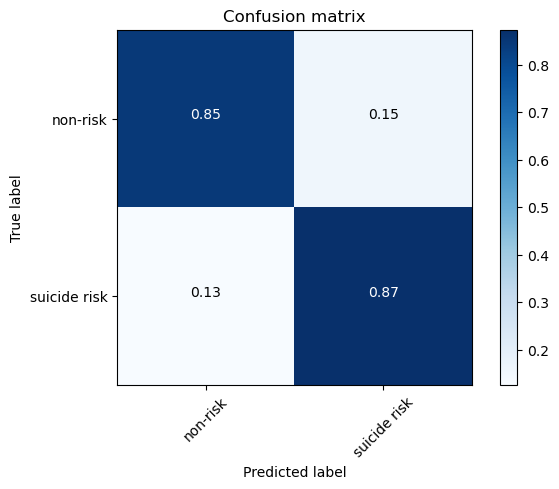

In [48]:
met.get_metrics('ssm', 'mnb', ssm_pipe, X_sent_train, y_train, X_sent_val, y_val)

In [38]:
met.df

,name,clf,cv_mean,train,acc,prec,rec,time
0,baseline,dummy,50.289,50.289,50.401,50.401,100.000,16.4 s
1,1st_sm,mnb,80.372,80.471,80.841,77.424,87.501,16.6 s
2,2nd_sm,mnb,85.711,85.717,85.975,85.169,87.392,17.2 s


#### Summary of MNB - 2

* Increased Accuracy (85.98%)
    * Model is well fit (0.2% under)
    * Quick
* Recall (87.39%) higher than Precision (85.17%)

---

## 3. Full Feature Models - Comparing Classifiers

### 3a. MNB - Full

In [49]:
mnb_pipe = Pipeline(steps=[
    ('prep', CT),
    ('mnb', MultinomialNB())
])

In [50]:
mnb_pipe

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('min',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15dae9250>),
                                                 ('text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x15e263ec0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.95,
                                                                                   min_df=0.05)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x15e263880>))]),
                                                  ['text'])])),
                ('mnb', MultinomialNB())])

TRAIN accuracy:  85.77 %
VAL:
Accuracy:  86.08 %
Recall:  8719.10 %
Precision:  85.48 %
Normalized confusion matrix
[[0.84944792 0.15055208]
 [0.12809015 0.87190985]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     17117
           1       0.85      0.87      0.86     17394

    accuracy                           0.86     34511
   macro avg       0.86      0.86      0.86     34511
weighted avg       0.86      0.86      0.86     34511



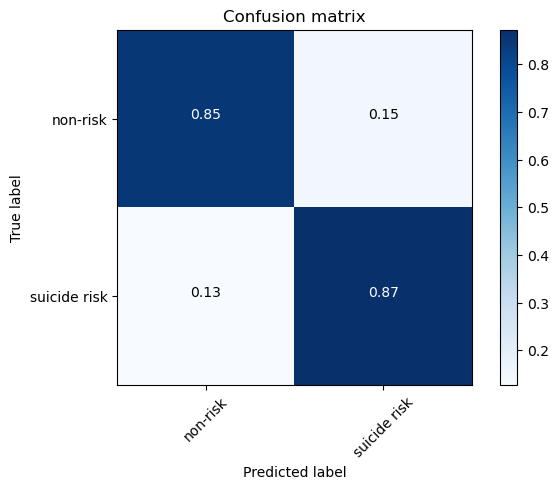

In [51]:
met.get_metrics('full', 'mnb', mnb_pipe, X_train, y_train, X_val, y_val)

In [52]:
met.df

,name,clf,cv_mean,train,acc,prec,rec,time
0,baseline,dummy,50.29,50.29,50.40,NaN,NaN,16.3 s
1,fsm,mnb,80.37,80.47,80.84,77.42,87.50,16.4 s
2,ssm,mnb,85.71,85.72,85.98,85.17,87.39,16.8 s
3,full,mnb,85.76,85.77,86.08,85.48,87.19,17.2 s


* Adding Emotion did very little to the MNB model
    * Slight accuracy improvement (0.1%)
    * Recall slightly worse (0.2%)
    * Slightly underfit (0.3%)

### 3b. Full - RFC

In [53]:
rfc_pipe = Pipeline(steps=[
    ('prep', CT),
    ('rfc', RandomForestClassifier(oob_score=True, n_jobs= -1, random_state=42))
])

TRAIN accuracy:  88.26 %
VAL:
Accuracy:  88.37 %
Recall:  8738.65 %
Precision:  89.32 %
Normalized confusion matrix
[[0.8937898  0.1062102 ]
 [0.12613545 0.87386455]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     17117
           1       0.89      0.87      0.88     17394

    accuracy                           0.88     34511
   macro avg       0.88      0.88      0.88     34511
weighted avg       0.88      0.88      0.88     34511



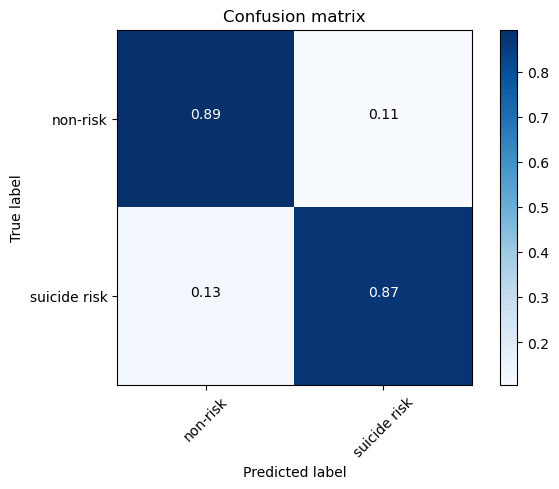

In [54]:
met.get_metrics('full', 'rfc', rfc_pipe, X_train, y_train, X_val, y_val)

In [55]:
met.df

,name,clf,cv_mean,train,acc,prec,rec,time
0,baseline,dummy,50.29,50.29,50.40,NaN,NaN,16.3 s
1,fsm,mnb,80.37,80.47,80.84,77.42,87.50,16.4 s
2,ssm,mnb,85.71,85.72,85.98,85.17,87.39,16.8 s
3,full,mnb,85.76,85.77,86.08,85.48,87.19,17.2 s
4,full,rfc,88.26,88.26,88.37,89.32,87.39,43.8 s


* Higher accuracy than MNB (88.3% vs. 86.1%)
* Well fit (0.1% under)
* However:
    * Much longer to run
    * Fails to minimize false negatives (precision > recall)
* STILL, recall is slightly better than MNB (87.4% vs. 87.2%)

**WINNER: RFC**


### 3c. Logistic Regression

In [56]:
lr_pipe = Pipeline(steps=[
    ('prep', CT),
    ('lr', LogisticRegression(
        solver='saga', random_state=42))
])

TRAIN accuracy:  88.93 %
VAL:
Accuracy:  88.87 %
Recall:  8721.97 %
Precision:  90.36 %
Normalized confusion matrix
[[0.90541567 0.09458433]
 [0.12780269 0.87219731]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     17117
           1       0.90      0.87      0.89     17394

    accuracy                           0.89     34511
   macro avg       0.89      0.89      0.89     34511
weighted avg       0.89      0.89      0.89     34511



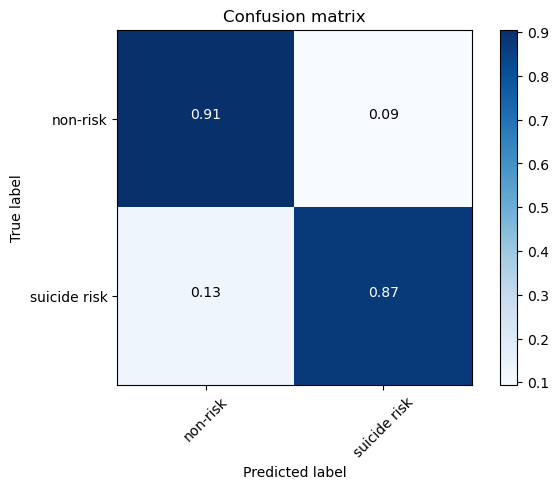

In [57]:
met.get_metrics('full', 'lr', lr_pipe, X_train, y_train, X_val, y_val)

In [58]:
met.df

,name,clf,cv_mean,train,acc,prec,rec,time
0,baseline,dummy,50.29,50.29,50.40,NaN,NaN,16.3 s
1,fsm,mnb,80.37,80.47,80.84,77.42,87.50,16.4 s
2,ssm,mnb,85.71,85.72,85.98,85.17,87.39,16.8 s
3,full,mnb,85.76,85.77,86.08,85.48,87.19,17.2 s
4,full,rfc,88.26,88.26,88.37,89.32,87.39,43.8 s
5,full,lr,88.86,88.93,88.87,90.36,87.22,31.8 s


* Higher accuracy than RFC or MNB (0.50%)
* Lower recall score than RFC (0.17%) & greater margin between precision and recall (3.14 vs. 1.93)

* However, margin can easily be altered by changing threshold:

In [59]:
y_pred_proba = lr_pipe.predict_proba(X_val)
lr_prc = pd.DataFrame(precision_recall_curve(y_val, y_pred_proba[:, 1])).T

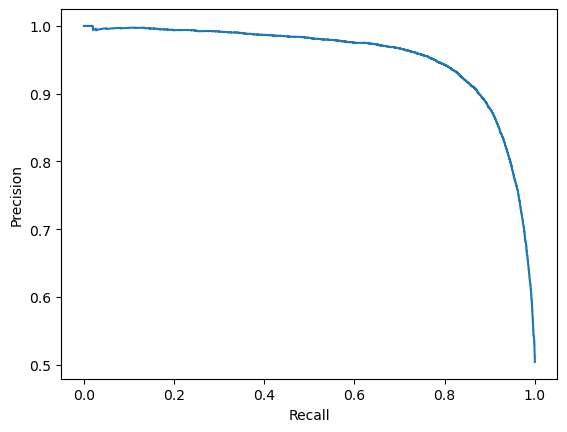

In [61]:
lr_prc.columns = ['precision', 'recall', 'threshold']

PrecisionRecallDisplay(precision=lr_prc['precision'], recall=lr_prc['recall']).plot();

In [63]:
lr_prc.mask(lr_prc['recall']<0.9).dropna().sort_values(by='precision', ascending=False)

,precision,recall,threshold
16251,0.88,0.90,0.40
16250,0.88,0.90,0.40
16248,0.88,0.90,0.40
16249,0.88,0.90,0.40
16246,0.88,0.90,0.40
...,...,...,...
4,0.50,1.00,0.00
3,0.50,1.00,0.00
2,0.50,1.00,0.00
1,0.50,1.00,0.00


* Lowering threshold will increase recall, so goal of hyperparameter tuning should be to increase AUC

**WINNER:** Logistic Regression Model

### 3d. SVM

In [64]:
svm_pipe = Pipeline(steps=[
    ('prep', CT),
    ('svm', LinearSVC(dual=False))
])

TRAIN accuracy:  88.98 %
VAL:
Accuracy:  88.90 %
Recall:  8684.60 %
Precision:  90.73 %
Normalized confusion matrix
[[0.90979728 0.09020272]
 [0.13153961 0.86846039]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     17117
           1       0.91      0.87      0.89     17394

    accuracy                           0.89     34511
   macro avg       0.89      0.89      0.89     34511
weighted avg       0.89      0.89      0.89     34511



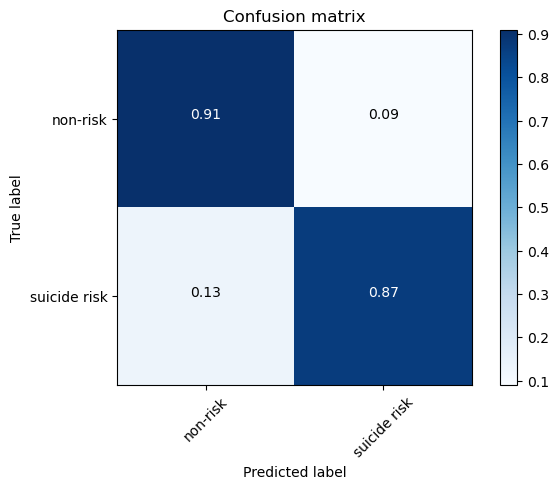

In [65]:
met.get_metrics('full', 'svm', svm_pipe, X_train, y_train, X_val, y_val)

In [66]:
met.df

,name,clf,cv_mean,train,acc,prec,rec,time
0,baseline,dummy,50.29,50.29,50.40,NaN,NaN,16.3 s
1,fsm,mnb,80.37,80.47,80.84,77.42,87.50,16.4 s
2,ssm,mnb,85.71,85.72,85.98,85.17,87.39,16.8 s
3,full,mnb,85.76,85.77,86.08,85.48,87.19,17.2 s
4,full,rfc,88.26,88.26,88.37,89.32,87.39,43.8 s
5,full,lr,88.86,88.93,88.87,90.36,87.22,31.8 s
6,full,svm,88.92,88.98,88.90,90.73,86.85,21.5 s


* While SVM has the highest accuracy, it also has the lowest recall rate.
* Logistic Regression is probably a better option, since accuracy is not that different between LR and SVM

## Best Full Feature Model:

LR  (88.9% Accuracy, 87.2% Recall, -3.14% RvP)

* Can change threshold to increase recall over precision

In [ ]:
# joblib.dump(lr_pipe, './models/3c_lr_pipe.joblib')

['./models/3c_lr_pipe.joblib']

---

# &nbsp;&nbsp; III. &nbsp; Hyperparameter Tuning

## Function for Grid Search Metrics

In [71]:
def get_grid_val_metrics(metrics, name, clf, pipe, Xtr, ytr, Xval, yval):

    start = time.time()

    met_dict = {'name':name, 'clf':clf}

    pipe.fit(X_train, y_train)
    yhat = pipe.predict(Xtr)
    met_dict['train'] = accuracy_score(ytr, yhat)*100

    ypred = pipe.predict(Xval)
    met_dict['acc'] = accuracy_score(yval, ypred)*100
    met_dict['prec'] = precision_score(yval, ypred)*100
    met_dict['rec'] = recall_score(yval, ypred)*100

    ypr = pipe.predict_proba(Xval)
    met_dict['roc_auc'] = roc_auc_score(yval, ypr[:,1])*100

    metrics = pd.concat([metrics, pd.DataFrame(met_dict, index=[0])], ignore_index=True)

    return metrics

In [72]:
metrics = pd.DataFrame()

In [73]:
metrics = get_grid_val_metrics(metrics, 'lr_pipe', 'lr', lr_pipe, X_train, y_train, X_val, y_val)

In [74]:
metrics

,name,clf,train,acc,prec,rec,roc_auc
0,lr_pipe,lr,88.93,88.87,90.36,87.22,95.14


---

## 1. Grid Search on Prep CT (Num Scaler and TF-IDF)

1. Type of Scaler & Normalization used on Numbers
2. TF-IDF min_df and max_df

In [75]:
lr_scoring = {'accuracy': make_scorer(accuracy_score),
              'roc_auc': make_scorer(roc_auc_score, needs_proba=True)}

In [76]:
numprep_params = {'prep__num__steps': [
        [('min', MinMaxScaler())],
        [('ss', StandardScaler()),
         ('norm', Normalizer(norm='l2'))],
        [('ss', StandardScaler()),
         ('norm', Normalizer(norm='l1'))],
        [('rs', RobustScaler()),
         ('norm', Normalizer(norm='l2'))],
        [('rs', RobustScaler()),
         ('norm', Normalizer(norm='l1'))] 
    ]
}

In [77]:
num_prep = GridSearchCV(
    estimator=lr_pipe,
    param_grid = numprep_params,
    scoring=lr_scoring, refit='roc_auc',
    cv=3, verbose=3)

In [78]:
num_prep.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END prep__num__steps=[('min', MinMaxScaler())]; accuracy: (test=0.890) roc_auc: (test=0.952) total time=   7.8s
[CV 2/3] END prep__num__steps=[('min', MinMaxScaler())]; accuracy: (test=0.889) roc_auc: (test=0.952) total time=   7.5s
[CV 3/3] END prep__num__steps=[('min', MinMaxScaler())]; accuracy: (test=0.887) roc_auc: (test=0.949) total time=   7.5s
[CV 1/3] END prep__num__steps=[('ss', StandardScaler()), ('norm', Normalizer())]; accuracy: (test=0.889) roc_auc: (test=0.952) total time=   6.4s
[CV 2/3] END prep__num__steps=[('ss', StandardScaler()), ('norm', Normalizer())]; accuracy: (test=0.890) roc_auc: (test=0.952) total time=   6.2s
[CV 3/3] END prep__num__steps=[('ss', StandardScaler()), ('norm', Normalizer())]; accuracy: (test=0.888) roc_auc: (test=0.950) total time=   6.3s
[CV 1/3] END prep__num__steps=[('ss', StandardScaler()), ('norm', Normalizer(norm='l1'))]; accuracy: (test=0.889) roc_auc: (test=0.952) tot

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('min',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x15dae9250>),
                                                                        ('text',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x15e263ec0>)),
                                                                                         ('tfidf',
                                                                                          TfidfVectorizer(max_df=0.95,
                                                                                                          min_df=0...
             param_grid={'prep__num__steps': [[('min', MinMaxScaler())],
                                              [('ss', StandardScaler()),
                                               ('norm', Normalizer())],
                                              [('ss', StandardScaler()),
                                               ('norm', Normalizer(norm='l1'))],
                                              [('rs', RobustScaler()),
                                               ('norm', Normalizer())],
                                              [('rs', RobustScaler()),
                                               ('norm',
                                                Normalizer(norm='l1'))]]},
             refit='roc_auc',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'roc_auc': make_scorer(roc_auc_score, needs_proba=True)},
             verbose=3)

In [88]:
print(num_prep.best_params_, num_prep.best_score_)


{'prep__num__steps': [('rs', RobustScaler()), ('norm', Normalizer())]} 0.9512438199032411


In [83]:
num_prep_pipe = num_prep.best_estimator_
num_prep_pipe

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler()),
                                                                  ('norm',
                                                                   Normalizer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17bbb5bd0>),
                                                 ('text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x15e263ec0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.95,
                                                                                   min_df=0.05)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x15e263880>))]),
                                                  ['text'])])),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [84]:
metrics = get_grid_val_metrics(metrics, 'num_prep_pipe', 'lr', num_prep_pipe, X_train, y_train, X_val, y_val)

In [85]:
metrics

,name,clf,train,acc,prec,rec,roc_auc
0,lr_pipe,lr,88.93,88.87,90.36,87.22,95.14
1,num_prep_pipe,lr,88.92,88.87,90.42,87.14,95.19


* Even though accuracy is unchanged and recall *decreases*, the AUC increases, which will help the recall rate when the threshold is changed.

---

### Manually Testing tf-idf min_df/max_df metric 
* Throws an error in GridSearch, possily because of custom function transfomers used

In [86]:
text_pipe = num_prep_pipe

In [87]:
text_pipe.set_params(prep__text__tfidf__max_df=0.99, prep__text__tfidf__min_df=0.01)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler()),
                                                                  ('norm',
                                                                   Normalizer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17bbb5bd0>),
                                                 ('text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x15e263ec0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_df=0.99,
                                                                                   min_df=0.01)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x15e263880>))]),
                                                  ['text'])])),
                ('lr', LogisticRegression(random_state=42, solver='saga'))])

In [89]:
metrics = get_grid_val_metrics(metrics, 'maxdf_99', 'lr', text_pipe, X_train, y_train, X_val, y_val)

In [90]:
metrics

,name,clf,train,acc,prec,rec,roc_auc
0,lr_pipe,lr,88.93,88.87,90.36,87.22,95.14
1,num_prep_pipe,lr,88.92,88.87,90.42,87.14,95.19
2,maxdf_99,lr,91.76,91.39,92.68,90.03,97.04


* Reducing df cutoff increases all metrics by 2 to 3%

In [92]:
words_added = len(lr_pipe['prep'].named_transformers_['text']['tfidf'].stop_words_) -\
              alen(text_pipe['prep'].named_transformers_['text']['tfidf'].stop_words_)

print(f"New model includes {words_added} words that were previously removed as stopwords.")

New model includes 564 words that were previously removed as stopwords.


---

## 2. Logistic Regression - Hyperparameter Tuning

In [110]:
# First, testing different L1 ratios with "ElasticNet" option on

text_pipe.set_params(**{'lr__penalty': 'elasticnet'})

lr_params = {
    'lr__l1_ratio': [0.0, 0.25, 0.75, 1.0],
    'lr__C': [1, 1000],
    'lr__tol': [0.0001, 0.000001]
}

In [111]:
lr_gs1 = GridSearchCV(
    estimator=text_pipe,
    param_grid=lr_params,
    scoring=lr_scoring, refit='roc_auc',
    cv=3, verbose=3)

In [112]:
start = time.time()

lr_gs1.fit(X_train, y_train)

end = time.time()

print('\n')
print(f'Time to fit: {(end - start) // 60} min {(end - start)%60:.0f} sec')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END lr__C=1, lr__l1_ratio=0.0, lr__tol=0.0001; accuracy: (test=0.916) roc_auc: (test=0.971) total time=  12.1s
[CV 2/3] END lr__C=1, lr__l1_ratio=0.0, lr__tol=0.0001; accuracy: (test=0.916) roc_auc: (test=0.971) total time=  11.9s
[CV 3/3] END lr__C=1, lr__l1_ratio=0.0, lr__tol=0.0001; accuracy: (test=0.914) roc_auc: (test=0.969) total time=  11.9s
[CV 1/3] END lr__C=1, lr__l1_ratio=0.0, lr__tol=1e-06; accuracy: (test=0.916) roc_auc: (test=0.971) total time=  15.6s
[CV 2/3] END lr__C=1, lr__l1_ratio=0.0, lr__tol=1e-06; accuracy: (test=0.916) roc_auc: (test=0.971) total time=  15.7s
[CV 3/3] END lr__C=1, lr__l1_ratio=0.0, lr__tol=1e-06; accuracy: (test=0.914) roc_auc: (test=0.969) total time=  16.2s
[CV 1/3] END lr__C=1, lr__l1_ratio=0.25, lr__tol=0.0001; accuracy: (test=0.916) roc_auc: (test=0.971) total time=  14.7s
[CV 2/3] END lr__C=1, lr__l1_ratio=0.25, lr__tol=0.0001; accuracy: (test=0.916) roc_auc: (test=0.971)

In [117]:
print(f'Best ROC-AUC: {lr_gs1.best_score_*100:.2f}, {lr_gs1.best_params_}')

Best ROC-AUC: 97.02, {'lr__C': 1, 'lr__l1_ratio': 0.75, 'lr__tol': 1e-06}


* Across all combinations: very little difference in accuracy and ROC-AUC Score
* Even though the "best_param" for tolerance is 1e-6, not much difference between 1e-4 and 1e-6 for tolerance.
    * Tolerance = 1e-4 is preferable because it's faster

* Best Parameters:
    * C = 1
    * L1_Ratio = 0.75
    * Tol = 1e-4 (speed)

In [120]:
lr_grid_pipe = text_pipe
lr_grid_pipe.set_params(**{'lr__l1_ratio': 0.75})
lr_grid_pipe['lr'].get_params()

{'C': 1.000,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.750,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'elasticnet',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.000,
 'verbose': 0,
 'warm_start': False}

In [122]:
metrics = get_grid_val_metrics(metrics, 'l1_ratio_75', 'lr', lr_grid_pipe, X_train, y_train, X_val, y_val)

In [123]:
metrics

,name,clf,train,acc,prec,rec,roc_auc
0,lr_pipe,lr,88.93,88.87,90.36,87.22,95.14
1,num_prep_pipe,lr,88.92,88.87,90.42,87.14,95.19
2,maxdf_99,lr,91.76,91.39,92.68,90.03,97.04
3,l1_ratio_75,lr,91.81,91.46,92.72,90.13,97.05


* Very little improvements in accuracy and roc_auc with hyperparameter tuning-- but still an improvement!

## 3. Altering Threshold to Increase Recall

In [124]:
y_pred_proba = lr_grid_pipe.predict_proba(X_val)
prc = pd.DataFrame(precision_recall_curve(y_val, y_pred_proba[:,1])).T

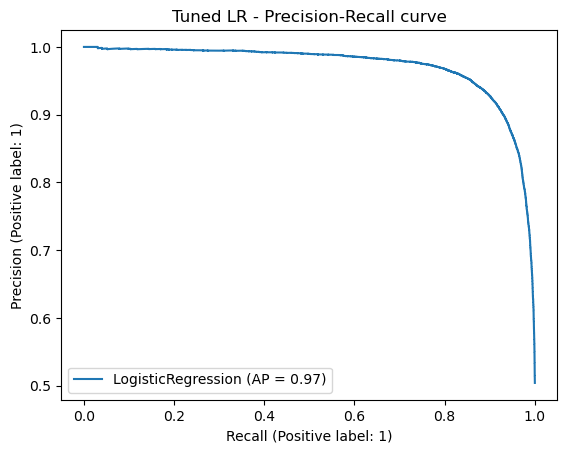

In [125]:
display = PrecisionRecallDisplay.from_estimator(lr_grid_pipe, X_val, y_val, name="LogisticRegression")
display.ax_.set_title("Tuned LR - Precision-Recall curve");

In [126]:
prc.columns = ['precision', 'recall', 'threshold']

In [127]:
prc.mask(prc['recall']<0.92).dropna().sort_values(by='precision', ascending=False)[:5]

,precision,recall,threshold
16771,0.91,0.92,0.41
16767,0.91,0.92,0.41
16768,0.91,0.92,0.41
16769,0.91,0.92,0.41
16770,0.91,0.92,0.41


* Testing a threshold of 0.4:

In [128]:
y_pred = np.where(lr_grid_pipe.predict_proba(X_val)[:,1] > 0.400, 1, 0)

In [129]:
print(accuracy_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred))

0.9137956014024514 0.9074314778185928 0.9231344141658043


In [135]:
metrics

,name,clf,train,acc,prec,rec,roc_auc
0,lr_pipe,lr,88.93,88.87,90.36,87.22,95.14
1,num_prep_pipe,lr,88.92,88.87,90.42,87.14,95.19
2,maxdf_99,lr,91.76,91.39,92.68,90.03,97.04
3,l1_ratio_75,lr,91.81,91.46,92.72,90.13,97.05


In [137]:
final_mets = {
    'name':'threshold',
    'clf':'lr',
    'train':'NA',
    'acc': accuracy_score(y_val, y_pred)*100,
    'prec': precision_score(y_val, y_pred)*100,
    'rec': recall_score(y_val, y_pred)*100,
    'roc_auc': roc_auc_score(y_val, y_pred)*100
}

In [141]:
metrics = pd.concat([metrics, pd.DataFrame(final_mets, index=[0])], ignore_index=True)

In [142]:
metrics

,name,clf,train,acc,prec,rec,roc_auc
0,lr_pipe,lr,88.93,88.87,90.36,87.22,95.14
1,num_prep_pipe,lr,88.92,88.87,90.42,87.14,95.19
2,maxdf_99,lr,91.76,91.39,92.68,90.03,97.04
3,l1_ratio_75,lr,91.81,91.46,92.72,90.13,97.05
4,threshold,lr,NA,91.38,90.74,92.31,91.37


* Using a threshold of 0.400 increases recall over precision, which lowers accuracy a little bit, but ultimately boosts recall.

### Saving Final Model Pipeline

In [143]:
final_pipe = lr_grid_pipe

In [144]:
joblib.dump(final_pipe, './streamlit/final_pipe.joblib')

['./streamlit/final_pipe.joblib']

---

# &nbsp;&nbsp; IV. &nbsp; Final Model Results

### Predicting X_test with Threshold = 0.4

In [145]:
y_hat = np.where(final_pipe.predict_proba(X_train)[:,1] > 0.400, 1, 0)

In [146]:
y_pred = np.where(final_pipe.predict_proba(X_test)[:,1] > 0.400, 1, 0)

In [159]:
test_metrics = {}
test_metrics['train'] = accuracy_score(y_train, y_hat)*100
test_metrics['accuracy'] = accuracy_score(y_test, y_pred)*100
test_metrics['precision'] = precision_score(y_test, y_pred)*100
test_metrics['recall'] = recall_score(y_test, y_pred)*100
test_metrics['roc_auc'] = roc_auc_score(y_test, y_pred)*100

In [163]:
print(f'Training Accuracy Score: {accuracy_score(y_train, y_hat)*100:.2f} %')
print('\t')
print("TEST SCORES:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100: .2f} %")
print(f"Recall: {recall_score(y_test, y_pred)*100: .2f} %")
print(f"Precision: {precision_score(y_test, y_pred)*100: .2f} %")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)*100: .2f} %")

Training Accuracy Score: 91.67 %
	
TEST SCORES:
Accuracy:  91.57 %
Recall:  92.43 %
Precision:  91.05 %
ROC AUC:  91.55 %


In [164]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     17034
           1       0.91      0.92      0.92     17477

    accuracy                           0.92     34511
   macro avg       0.92      0.92      0.92     34511
weighted avg       0.92      0.92      0.92     34511



In [165]:
conf = confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[0.90677469 0.09322531]
 [0.07569949 0.92430051]]


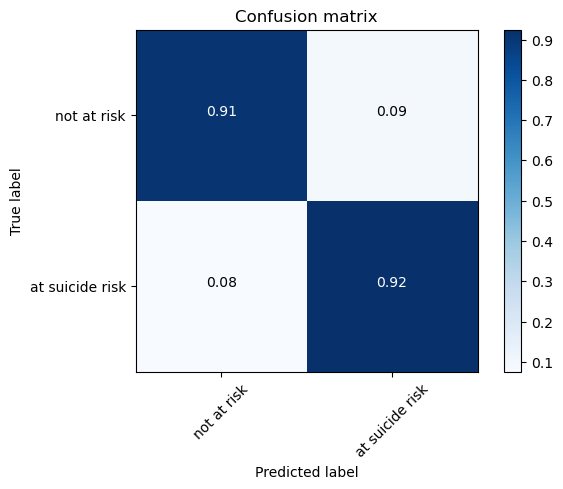

In [166]:
plot_confusion_matrix(conf,
                      classes=['not at risk', 'at suicide risk'],
                      normalize=True)

* 91.5% accuracy
* Model is well fit (train score similar to test score)
* Runs quickly (~30 seconds)
* Recall (92%) rate higher than Precision (91%)

## ROC AUC Plot

In [179]:
# display = RocCurveDisplay.from_predictions(y_test, y_pred)

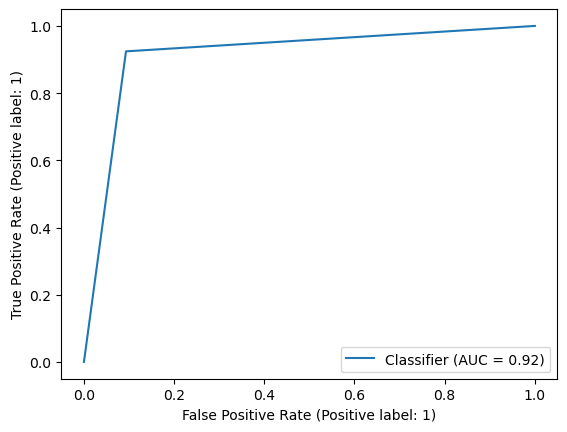

In [180]:
RocCurveDisplay.plot(display);
plt.savefig('./images/6-rocauc.png', bbox_inches='tight', pad_inches=0.1, facecolor='white', transparent=False)

## Top 10 Features by Coefficients

In [181]:
feature_names = list(final_pipe['prep'].named_transformers_['num'].get_feature_names_out()) + \
                list(final_pipe['prep'].named_transformers_['text']['tfidf'].get_feature_names_out())

In [182]:
final_feats = pd.DataFrame(final_pipe['lr'].coef_).T
final_feats.index = feature_names
final_feats.columns = ['weights']
final_feats = final_feats.reset_index()

In [183]:
final_feats_top10 = final_feats.sort_values(by='weights', ascending=False)[:10]
final_feats_top10['weights'] = final_feats_top10['weights'].round(1)
final_feats_top10.columns = ['features', 'weights']

In [184]:
final_feats_top10

,features,weights
632,suicide,11.80
631,suicidal,11.20
499,pill,7.30
477,overdose,7.30
363,kill,7.10
46,anymore,5.90
207,end,5.60
29,alive,5.50
412,medication,5.40
334,hopeless,5.40


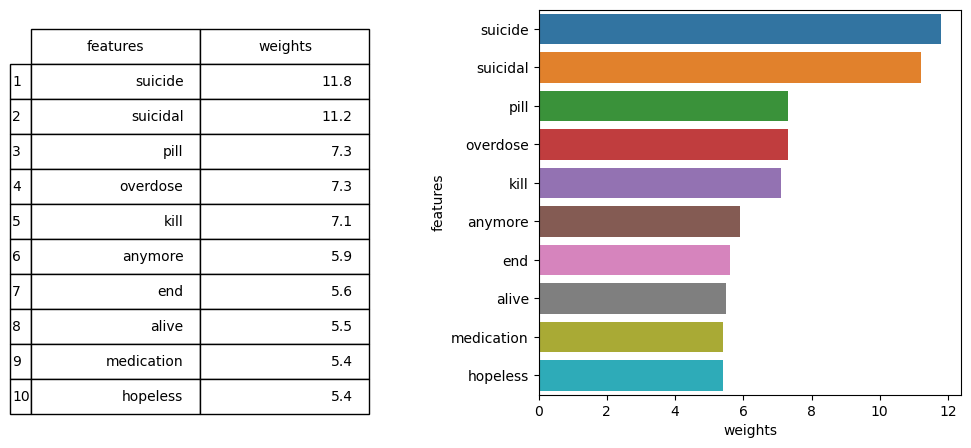

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].axis("off");
ax[0].table(cellText=final_feats_top10.values, rowLabels=range(1,11), bbox=[0,-0.05,0.8,1], colLabels=final_feats_top10.columns);

sns.barplot(final_feats_top10, x = 'weights', y = 'features', orient='h', ax=ax[1]);

* Top features are all terms related to suicide
* Interestingly, emotion and sentiment components are not among the top 10 features
    * Could be that emotion and sentiment are not as specific to suicidal text as these particular words
    * Likely due to multicollinearity of Emotion & Sentiment scores-- next step is to try to address this

# &nbsp;&nbsp; V. &nbsp; Model Deployment

* This model is intended to work alongside a mental health chatbot. 
* I plan to work with my stakeholders to build this model into the current framework of their mental health chatbots, in collaboration with their IT support team and clinicians to ensure the most ethical practices are used.

* So that you can see how this model would work, I have created a demo page where you can see how the model would classify user-inputted text.
    * Currently, still some issues with server deployment due to package dependencies
* For now, the model is available to test by downloading the environment yaml on Github and running the following code through terminal:

---

Below are screenshots of the model's classification of Suicide Risk vs. Non-Risk Text:

### Suicide Risk:
    
![riskdemo](./images/8-suicrisk_demo.png)

### No Risk:
    
![noriskdemo](./images/7-norisk_demo.png)

# &nbsp;&nbsp; VI. &nbsp; Conclusions

## Final Model Evaluation

The final model meets all of the project goals stated in the Introduction:

#### Objective #1: Accurately classify text as indicative of suicide risk vs. non risk
* <u>91.5% Accuracy</u> - The model correctly classified text as indicative of suicide-risk vs. non-risk for *91.5%* of cases.
<br>
#### Objective #2: Minimize False Negatives
* <u>92.5% Sensitivity (Recall)</u> - The model minimizes *false negative classifications*
* Only fails to detect suicide risk in 7.5% of cases
    * This is impressive, given that even [clinician recall rates](https://onlinelibrary.wiley.com/doi/10.1111/sltb.12395) range from 20 - 50%. 
<br>
#### Objective #3: Deployed Model is able to quickly generate new predictions
* Deployed Model provides predictions from new text within seconds

---

## Next Steps

#### 1. Integrate model to work alongside existing mental health chatbot frameworks
* Collaborate with clinicians to determine the best way to implement this model: what should be the response if someone is flagged for suicide risk?
    * Possible options include:
        1. Model automatically alerts on-call clinical risk team
        2. If suicide risk detected, train mental health chatbot to conduct [standardized suicide risk assessment](https://psy.fsu.edu/~joinerlab/measures/Joiner%20Lab--Risk%20Assessment.pdf)
        3. Train mental health chatbot to conduct risk-reduction techniques, such as [making a safety plan](https://988lifeline.org/help-yourself/)

#### 2. Continue Training Model with new data
* To improve model performance for your clients' specific needs, the model should be trained on actual chatbot conversations. The training data can be anonymized to protect client confidentiality.

#### 3. Train Model to interpret Misspellings, Slang Words, and common Medical Abbreviations
* Current Model does not use SpellCheck because of the time/computational power required, and SpellCheck changes altering sentence meanings
    * Could help to use a spellcheck model like [contextualSpellCheck](https://pypi.org/project/contextualSpellCheck/) that is trained not to autocorrect common slang terms and medical terms (e.g. medication names, therapy names)
* Current Model does not assign emotion/sentiment scores to Slang Words/Medical Terms
    * Update feature extraction tools to understand sentiment of these terms
    
#### 4. Incorporate other Natural Language Processing Models and Techniques
* Named Entity Recognition can be used to classify terms related to top features in current model
    * e,g,: "Pill" is a top term-- associated with proper medication names (e.g. "sertraline", "klonopin", etc.)
* Using [MentalBERT](https://arxiv.org/abs/2110.15621): pre-trained masked language models specific to mental health
* Topic Modeling / Finding semantic vectors with [Genism](https://radimrehurek.com/gensim/)